In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F


dropout_value = 0.1

def conv_bn_act(in_ch, out_ch, kernel=3, stride=1, padding=1, dilation=1, dropout_p=0.05):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=kernel, stride=stride,
                  padding=padding, dilation=dilation, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_p)
    )

def dws_bn_act(in_ch, out_ch, kernel_size=3, stride=1, padding=1, dilation=1,dropout_p=0.05):
    return nn.Sequential(
        nn.Conv2d(in_ch, in_ch, kernel_size=kernel_size, stride=stride,
                            padding=padding, dilation=dilation, groups=in_ch, bias=False),
        nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_p)
    )

class Model1(nn.Module):
    def __init__(self, num_classes):
        super(Model1, self).__init__()

        # CONVOLUTION BLOCK 1
        self.c1_1 = conv_bn_act(3, 32, kernel=3, stride=1, padding=1, dilation=1)
        self.c1_2 = conv_bn_act(32, 64, kernel=3, stride=2, padding=1, dilation=1)
        self.onexonec1_1 = conv_bn_act(64, 32, kernel=1, stride=1, padding=0, dilation=1)

        # CONVOLUTION BLOCK 2
        self.c2_1 = conv_bn_act(32, 64, kernel=3, stride=1, padding=1, dilation=1)
        self.c2_2 = dws_bn_act(64, 32, kernel_size=3, stride=2, padding=1, dilation=1)
        #self.onexonec2_1 = conv_bn_act(64, 32, kernel=1, stride=1, padding=0, dilation=1)

        # CONVOLUTION BLOCK 3
        self.c3_1 = conv_bn_act(32, 64, kernel=3, stride=1, padding=1, dilation=1)
        self.c3_2 = conv_bn_act(64, 64, kernel=3, stride=2, padding=1, dilation=1)
        self.onexonec3_1 = conv_bn_act(64, 32, kernel=1, stride=1, padding=0, dilation=1)

        # CONVOLUTION BLOCK 4
        self.c4 = conv_bn_act(32, 64, kernel=3, stride=1, padding=1, dilation=1)
        self.c5 = conv_bn_act(64, 64, kernel=3, stride=1, padding=1, dilation=2)

        # OUTPUT BLOCK
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, num_classes)


    def forward(self, x):
        # Block 1
        x = self.c1_1(x)
        x = self.c1_2(x)
        x = self.onexonec1_1(x)

        # Block 2
        x = self.c2_1(x)
        x = self.c2_2(x)
        #x = self.onexonec2_1(x)

        # Block 3
        x = self.c3_1(x)
        x = self.c3_2(x)
        x = self.onexonec3_1(x)

        # Block 4 (dilated)
        x = self.c4(x)
        x = self.c5(x)

        # Output Block
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        # x = x.view(-1, 10)
        return x

In [29]:
import matplotlib.pyplot as plt


def plot_metrics(train_losses, test_losses, train_acc, test_acc):
    epochs = range(1, len(train_acc) + 1)

    # ----------------------
    # Plot Train Loss
    # ----------------------
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Train Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------
    # Plot Test Loss
    # ----------------------
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, test_losses, 'r-', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------
    # Plot Train Accuracy
    # ----------------------
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_acc, 'g-', label='Train Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (%)')
    plt.title('Train Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------
    # Plot Test Accuracy
    # ----------------------
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, test_acc, 'm-', label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

CUDA Available? True
Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 16, 16]          18,432
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
           Dropout-8           [-1, 64, 16, 16]               0
            Conv2d-9           [-1, 32, 16, 16]           2,048
      BatchNorm2d-10           [-1, 32, 16, 16]              64
             ReLU-11           [-1, 32, 16, 16]               0
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432

Epoch=1 Loss=1.9529 Accuracy=19.27: 100%|██████████| 391/391 [00:17<00:00, 21.80it/s]



Test set: Average loss: 0.0156, Accuracy: 2658/10000 (26.58%)

found perfect model!!
Saved best model (acc=26.58%) to best_model.pth

EPOCH: 2


Epoch=2 Loss=1.8613 Accuracy=30.66: 100%|██████████| 391/391 [00:18<00:00, 21.02it/s]



Test set: Average loss: 0.0137, Accuracy: 3659/10000 (36.59%)

found perfect model!!
Saved best model (acc=36.59%) to best_model.pth

EPOCH: 3


Epoch=3 Loss=1.7675 Accuracy=37.03: 100%|██████████| 391/391 [00:17<00:00, 22.02it/s]



Test set: Average loss: 0.0123, Accuracy: 4339/10000 (43.39%)

found perfect model!!
Saved best model (acc=43.39%) to best_model.pth

EPOCH: 4


Epoch=4 Loss=1.4366 Accuracy=42.62: 100%|██████████| 391/391 [00:18<00:00, 21.41it/s]



Test set: Average loss: 0.0108, Accuracy: 4906/10000 (49.06%)

found perfect model!!
Saved best model (acc=49.06%) to best_model.pth

EPOCH: 5


Epoch=5 Loss=1.3381 Accuracy=46.84: 100%|██████████| 391/391 [00:17<00:00, 22.15it/s]



Test set: Average loss: 0.0100, Accuracy: 5380/10000 (53.80%)

found perfect model!!
Saved best model (acc=53.80%) to best_model.pth

EPOCH: 6


Epoch=6 Loss=1.2481 Accuracy=50.84: 100%|██████████| 391/391 [00:18<00:00, 20.75it/s]



Test set: Average loss: 0.0092, Accuracy: 5824/10000 (58.24%)

found perfect model!!
Saved best model (acc=58.24%) to best_model.pth

EPOCH: 7


Epoch=7 Loss=1.1447 Accuracy=53.87: 100%|██████████| 391/391 [00:17<00:00, 22.13it/s]



Test set: Average loss: 0.0088, Accuracy: 6025/10000 (60.25%)

found perfect model!!
Saved best model (acc=60.25%) to best_model.pth

EPOCH: 8


Epoch=8 Loss=1.0814 Accuracy=56.90: 100%|██████████| 391/391 [00:19<00:00, 20.21it/s]



Test set: Average loss: 0.0079, Accuracy: 6422/10000 (64.22%)

found perfect model!!
Saved best model (acc=64.22%) to best_model.pth

EPOCH: 9


Epoch=9 Loss=1.1488 Accuracy=59.40: 100%|██████████| 391/391 [00:17<00:00, 22.08it/s]



Test set: Average loss: 0.0074, Accuracy: 6693/10000 (66.93%)

found perfect model!!
Saved best model (acc=66.93%) to best_model.pth

EPOCH: 10


Epoch=10 Loss=1.0479 Accuracy=61.86: 100%|██████████| 391/391 [00:18<00:00, 20.98it/s]



Test set: Average loss: 0.0071, Accuracy: 6781/10000 (67.81%)

found perfect model!!
Saved best model (acc=67.81%) to best_model.pth

EPOCH: 11


Epoch=11 Loss=0.9079 Accuracy=63.61: 100%|██████████| 391/391 [00:17<00:00, 21.86it/s]



Test set: Average loss: 0.0072, Accuracy: 6724/10000 (67.24%)


EPOCH: 12


Epoch=12 Loss=1.0141 Accuracy=65.03: 100%|██████████| 391/391 [00:18<00:00, 20.99it/s]



Test set: Average loss: 0.0069, Accuracy: 6934/10000 (69.34%)

found perfect model!!
Saved best model (acc=69.34%) to best_model.pth

EPOCH: 13


Epoch=13 Loss=0.9654 Accuracy=66.36: 100%|██████████| 391/391 [00:17<00:00, 22.04it/s]



Test set: Average loss: 0.0060, Accuracy: 7310/10000 (73.10%)

found perfect model!!
Saved best model (acc=73.10%) to best_model.pth

EPOCH: 14


Epoch=14 Loss=0.7606 Accuracy=67.68: 100%|██████████| 391/391 [00:18<00:00, 20.89it/s]



Test set: Average loss: 0.0062, Accuracy: 7264/10000 (72.64%)


EPOCH: 15


Epoch=15 Loss=0.8667 Accuracy=68.16: 100%|██████████| 391/391 [00:17<00:00, 21.98it/s]



Test set: Average loss: 0.0057, Accuracy: 7474/10000 (74.74%)

found perfect model!!
Saved best model (acc=74.74%) to best_model.pth

EPOCH: 16


Epoch=16 Loss=0.8369 Accuracy=68.92: 100%|██████████| 391/391 [00:18<00:00, 21.39it/s]



Test set: Average loss: 0.0053, Accuracy: 7651/10000 (76.51%)

found perfect model!!
Saved best model (acc=76.51%) to best_model.pth

EPOCH: 17


Epoch=17 Loss=0.9107 Accuracy=69.80: 100%|██████████| 391/391 [00:17<00:00, 22.26it/s]



Test set: Average loss: 0.0051, Accuracy: 7759/10000 (77.59%)

found perfect model!!
Saved best model (acc=77.59%) to best_model.pth

EPOCH: 18


Epoch=18 Loss=0.9473 Accuracy=70.56: 100%|██████████| 391/391 [00:17<00:00, 21.83it/s]



Test set: Average loss: 0.0048, Accuracy: 7903/10000 (79.03%)

found perfect model!!
Saved best model (acc=79.03%) to best_model.pth

EPOCH: 19


Epoch=19 Loss=0.8002 Accuracy=71.07: 100%|██████████| 391/391 [00:18<00:00, 21.72it/s]



Test set: Average loss: 0.0048, Accuracy: 7939/10000 (79.39%)

found perfect model!!
Saved best model (acc=79.39%) to best_model.pth

EPOCH: 20


Epoch=20 Loss=0.7656 Accuracy=71.77: 100%|██████████| 391/391 [00:17<00:00, 22.07it/s]



Test set: Average loss: 0.0050, Accuracy: 7807/10000 (78.07%)


EPOCH: 21


Epoch=21 Loss=0.6373 Accuracy=72.55: 100%|██████████| 391/391 [00:18<00:00, 21.03it/s]



Test set: Average loss: 0.0048, Accuracy: 7880/10000 (78.80%)


EPOCH: 22


Epoch=22 Loss=0.9156 Accuracy=73.05: 100%|██████████| 391/391 [00:17<00:00, 22.05it/s]



Test set: Average loss: 0.0045, Accuracy: 8017/10000 (80.17%)

found perfect model!!
Saved best model (acc=80.17%) to best_model.pth

EPOCH: 23


Epoch=23 Loss=0.7645 Accuracy=73.39: 100%|██████████| 391/391 [00:18<00:00, 20.79it/s]



Test set: Average loss: 0.0050, Accuracy: 7853/10000 (78.53%)


EPOCH: 24


Epoch=24 Loss=0.9480 Accuracy=73.78: 100%|██████████| 391/391 [00:17<00:00, 21.95it/s]



Test set: Average loss: 0.0044, Accuracy: 8084/10000 (80.84%)

found perfect model!!
Saved best model (acc=80.84%) to best_model.pth

EPOCH: 25


Epoch=25 Loss=0.7726 Accuracy=74.04: 100%|██████████| 391/391 [00:18<00:00, 20.87it/s]



Test set: Average loss: 0.0045, Accuracy: 8067/10000 (80.67%)


EPOCH: 26


Epoch=26 Loss=0.6494 Accuracy=74.48: 100%|██████████| 391/391 [00:17<00:00, 22.01it/s]



Test set: Average loss: 0.0042, Accuracy: 8157/10000 (81.57%)

found perfect model!!
Saved best model (acc=81.57%) to best_model.pth

EPOCH: 27


Epoch=27 Loss=0.7419 Accuracy=74.74: 100%|██████████| 391/391 [00:18<00:00, 20.63it/s]



Test set: Average loss: 0.0044, Accuracy: 8052/10000 (80.52%)


EPOCH: 28


Epoch=28 Loss=0.8597 Accuracy=75.19: 100%|██████████| 391/391 [00:17<00:00, 22.02it/s]



Test set: Average loss: 0.0042, Accuracy: 8200/10000 (82.00%)

found perfect model!!
Saved best model (acc=82.00%) to best_model.pth

EPOCH: 29


Epoch=29 Loss=0.6548 Accuracy=75.28: 100%|██████████| 391/391 [00:18<00:00, 20.71it/s]



Test set: Average loss: 0.0043, Accuracy: 8100/10000 (81.00%)


EPOCH: 30


Epoch=30 Loss=0.6823 Accuracy=75.81: 100%|██████████| 391/391 [00:17<00:00, 21.88it/s]



Test set: Average loss: 0.0039, Accuracy: 8255/10000 (82.55%)

found perfect model!!
Saved best model (acc=82.55%) to best_model.pth

EPOCH: 31


Epoch=31 Loss=0.7893 Accuracy=75.97: 100%|██████████| 391/391 [00:18<00:00, 20.79it/s]



Test set: Average loss: 0.0039, Accuracy: 8302/10000 (83.02%)

found perfect model!!
Saved best model (acc=83.02%) to best_model.pth

EPOCH: 32


Epoch=32 Loss=0.6393 Accuracy=76.29: 100%|██████████| 391/391 [00:17<00:00, 22.10it/s]



Test set: Average loss: 0.0039, Accuracy: 8280/10000 (82.80%)


EPOCH: 33


Epoch=33 Loss=0.7367 Accuracy=76.44: 100%|██████████| 391/391 [00:18<00:00, 21.15it/s]



Test set: Average loss: 0.0041, Accuracy: 8267/10000 (82.67%)


EPOCH: 34


Epoch=34 Loss=0.7856 Accuracy=76.66: 100%|██████████| 391/391 [00:17<00:00, 21.91it/s]



Test set: Average loss: 0.0039, Accuracy: 8315/10000 (83.15%)

found perfect model!!
Saved best model (acc=83.15%) to best_model.pth

EPOCH: 35


Epoch=35 Loss=0.6380 Accuracy=76.87: 100%|██████████| 391/391 [00:18<00:00, 20.81it/s]



Test set: Average loss: 0.0038, Accuracy: 8327/10000 (83.27%)

found perfect model!!
Saved best model (acc=83.27%) to best_model.pth

EPOCH: 36


Epoch=36 Loss=0.4856 Accuracy=77.23: 100%|██████████| 391/391 [00:18<00:00, 21.40it/s]



Test set: Average loss: 0.0039, Accuracy: 8328/10000 (83.28%)

found perfect model!!
Saved best model (acc=83.28%) to best_model.pth

EPOCH: 37


Epoch=37 Loss=0.4203 Accuracy=77.30: 100%|██████████| 391/391 [00:19<00:00, 20.39it/s]



Test set: Average loss: 0.0037, Accuracy: 8431/10000 (84.31%)

found perfect model!!
Saved best model (acc=84.31%) to best_model.pth

EPOCH: 38


Epoch=38 Loss=0.7004 Accuracy=77.92: 100%|██████████| 391/391 [00:18<00:00, 21.32it/s]



Test set: Average loss: 0.0036, Accuracy: 8414/10000 (84.14%)


EPOCH: 39


Epoch=39 Loss=0.6069 Accuracy=78.06: 100%|██████████| 391/391 [00:18<00:00, 20.62it/s]



Test set: Average loss: 0.0038, Accuracy: 8341/10000 (83.41%)


EPOCH: 40


Epoch=40 Loss=0.4174 Accuracy=77.86: 100%|██████████| 391/391 [00:18<00:00, 21.12it/s]



Test set: Average loss: 0.0038, Accuracy: 8364/10000 (83.64%)


EPOCH: 41


Epoch=41 Loss=0.7069 Accuracy=78.36: 100%|██████████| 391/391 [00:19<00:00, 20.04it/s]



Test set: Average loss: 0.0039, Accuracy: 8347/10000 (83.47%)


EPOCH: 42


Epoch=42 Loss=0.5097 Accuracy=78.71: 100%|██████████| 391/391 [00:18<00:00, 21.39it/s]



Test set: Average loss: 0.0036, Accuracy: 8411/10000 (84.11%)


EPOCH: 43


Epoch=43 Loss=0.6240 Accuracy=78.54: 100%|██████████| 391/391 [00:19<00:00, 19.93it/s]



Test set: Average loss: 0.0035, Accuracy: 8494/10000 (84.94%)

found perfect model!!
Saved best model (acc=84.94%) to best_model.pth

EPOCH: 44


Epoch=44 Loss=0.5916 Accuracy=79.06: 100%|██████████| 391/391 [00:18<00:00, 21.29it/s]



Test set: Average loss: 0.0035, Accuracy: 8472/10000 (84.72%)


EPOCH: 45


Epoch=45 Loss=0.8245 Accuracy=78.76: 100%|██████████| 391/391 [00:19<00:00, 20.20it/s]



Test set: Average loss: 0.0035, Accuracy: 8486/10000 (84.86%)


EPOCH: 46


Epoch=46 Loss=0.6846 Accuracy=79.21: 100%|██████████| 391/391 [00:18<00:00, 21.23it/s]



Test set: Average loss: 0.0036, Accuracy: 8482/10000 (84.82%)


EPOCH: 47


Epoch=47 Loss=0.4846 Accuracy=79.40: 100%|██████████| 391/391 [00:19<00:00, 20.06it/s]



Test set: Average loss: 0.0036, Accuracy: 8435/10000 (84.35%)


EPOCH: 48


Epoch=48 Loss=0.5071 Accuracy=79.57: 100%|██████████| 391/391 [00:18<00:00, 21.47it/s]



Test set: Average loss: 0.0035, Accuracy: 8462/10000 (84.62%)


EPOCH: 49


Epoch=49 Loss=0.5197 Accuracy=79.93: 100%|██████████| 391/391 [00:19<00:00, 20.18it/s]



Test set: Average loss: 0.0034, Accuracy: 8529/10000 (85.29%)

found perfect model!!
Saved best model (acc=85.29%) to best_model.pth
-----------------------------------------
train accuracies 49 [19.274, 30.658, 37.03, 42.622, 46.836, 50.842, 53.872, 56.898, 59.398, 61.856, 63.606, 65.03, 66.356, 67.68, 68.158, 68.916, 69.798, 70.56, 71.07, 71.768, 72.546, 73.052, 73.388, 73.784, 74.038, 74.476, 74.738, 75.194, 75.28, 75.808, 75.966, 76.286, 76.442, 76.658, 76.866, 77.232, 77.298, 77.924, 78.064, 77.856, 78.36, 78.708, 78.542, 79.064, 78.756, 79.208, 79.4, 79.566, 79.926]
train losses 49 [843.7967319488525, 742.194667339325, 672.498405456543, 613.3597923517227, 569.9025815725327, 533.226804971695, 499.0963227748871, 468.2384566664696, 442.5828979611397, 418.0351377129555, 399.13623851537704, 383.7385153770447, 371.24620628356934, 356.9255430698395, 351.1351715326309, 341.5843279361725, 334.5348949432373, 323.60550075769424, 317.98453986644745, 311.47157222032547, 303.92007756233215, 3

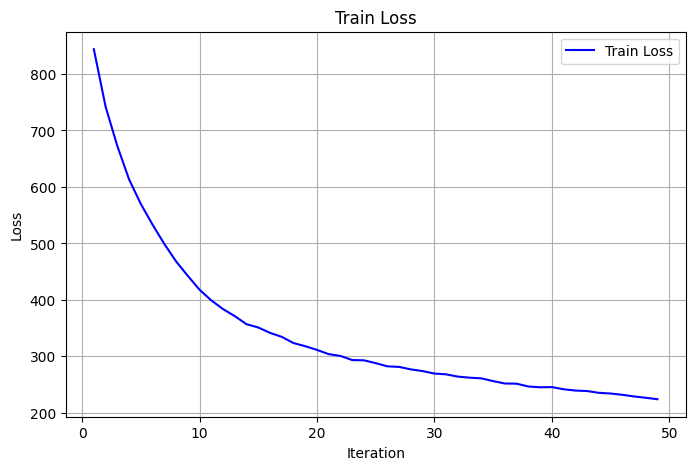

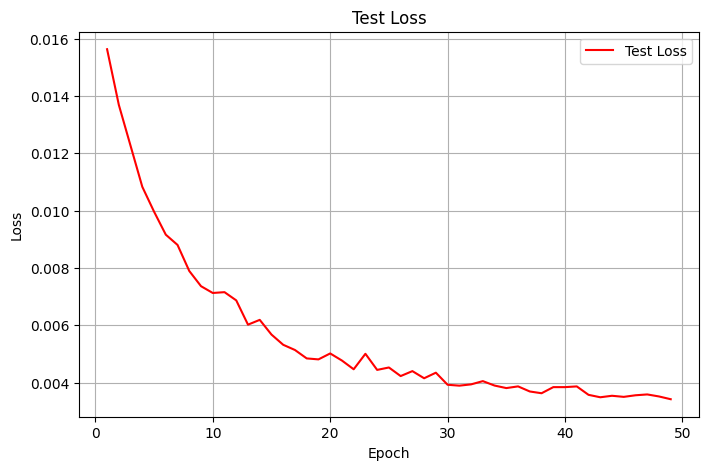

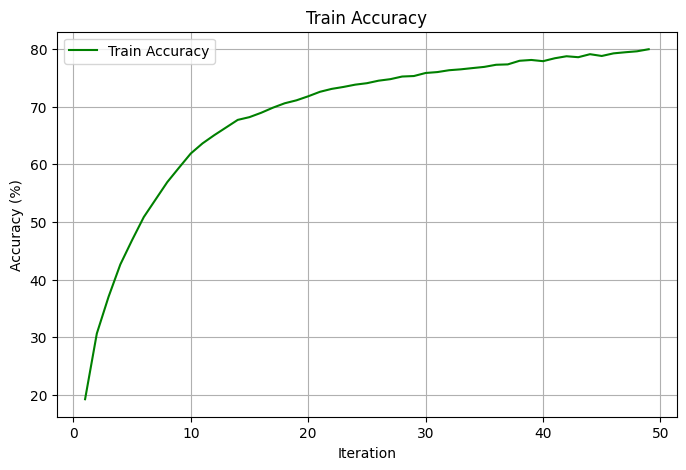

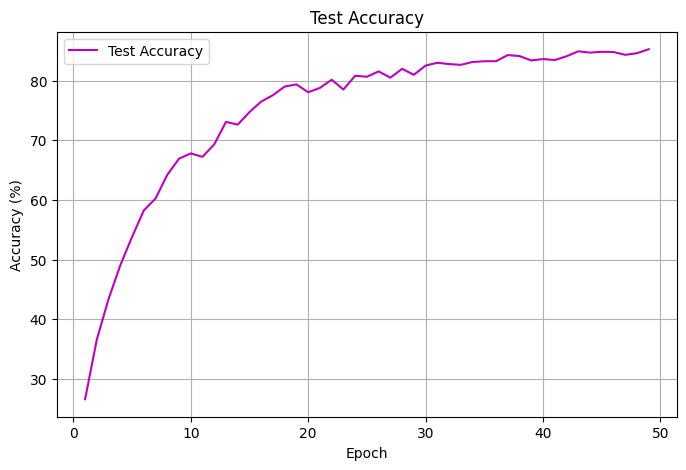

In [30]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from tqdm import tqdm
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import OneCycleLR
# from models import Model1
# from utils import plot_metrics


def train(model, device, train_loader, optimizer, scheduler, criterion, epoch, train_losses, train_acc):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(y_pred, target)   # expects log_softmax in model forward
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        # if batch_idx > 5:
        #     break
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        acc = 100. * correct / processed
        pbar.set_description(desc=f'Epoch={epoch} Loss={loss.item():.4f} Accuracy={acc:0.2f}')
        #train_acc.append(acc)
    train_losses.append(train_loss)
    acc = 100. * correct / len(train_loader.dataset)
    train_acc.append(acc)


def test(model, device, test_loader, criterion, test_losses, test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc.append(acc)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n')
    return acc

def get_data_loaders():
    # CIFAR-10 mean and std
    CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
    CIFAR10_STD  = (0.2470, 0.2435, 0.2616)


    fill_value_pixels = tuple(int(m * 255) for m in CIFAR10_MEAN)

    train_alb = A.Compose([
        A.HorizontalFlip(p=0.5),
         A.Affine(
            translate_percent={"x": 0.0625, "y": 0.0625},  # shift
            scale=(0.9, 1.1),                               # scale
            rotate=(-15, 15),                               # rotation
            p=0.5
        ),
        A.CoarseDropout(
            num_holes_range=(1, 1),
            hole_height_range=(16, 16),
            hole_width_range=(16, 16),
            fill=fill_value_pixels,
            fill_mask=None,
            p=0.5
        ),
        A.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD),
        ToTensorV2(),
    ])

    val_alb = A.Compose([
        A.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD),
        ToTensorV2(),
    ])

    class AlbCIFAR10(datasets.CIFAR10):
        def __init__(self, root, train=True, transform=None, download=False):
            super().__init__(root=root, train=train, download=download)
            self.alb_transform = transform

        def __getitem__(self, index):
            img, target = self.data[index], int(self.targets[index])
            # img is HxWxC numpy (uint8)
            if self.alb_transform:
                augmented = self.alb_transform(image=img)
                img = augmented["image"]
            else:
                # fallback: convert to tensor and normalize
                img = transforms.ToTensor()(img)
            return img, target



    # train_transforms = transforms.Compose([
    #     transforms.RandomHorizontalFlip(),
    #     transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean, std)
    # ])

    # test_transforms = transforms.Compose([
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean, std)
    # ])

    # train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
    # test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

    train = AlbCIFAR10(root='./data', train=True, transform=train_alb, download=True)
    test   = AlbCIFAR10(root='./data', train=False, transform=val_alb, download=True)

    SEED = 1
    cuda = torch.cuda.is_available()
    print("CUDA Available?", cuda)
    torch.manual_seed(SEED)
    if cuda:
        torch.cuda.manual_seed(SEED)

    dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda \
                      else dict(shuffle=True, batch_size=64)
    train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
    test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
    return train_loader, test_loader, cuda

def perform_training():
    train_loader, test_loader, use_cuda = get_data_loaders()
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Using device:", device)

    number_of_classes = 10
    model = Model1(number_of_classes).to(device)
    summary(model, input_size=(3, 32, 32))  # CIFAR-10 input size

    # return
    #optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
    # optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

    # scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    EPOCHS = 80
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,
        steps_per_epoch=len(train_loader),

        epochs=EPOCHS,
        pct_start=0.2,
        anneal_strategy="cos",
    )

    EPOCHS = 100
    SAVE_PATH = "best_model.pth"

    train_losses, test_losses, train_acc, test_acc = [], [], [], []
    best_val_acc = 0.0

    for epoch in range(1, EPOCHS + 1):
        print(f"\nEPOCH: {epoch}")
        train(model, device, train_loader, optimizer, scheduler, criterion, epoch, train_losses, train_acc)
        current_test_acc = test(model, device, test_loader, criterion, test_losses, test_acc)
        if current_test_acc >= best_val_acc:
            print("found perfect model!!")
            best_val_acc = current_test_acc
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "val_acc": current_test_acc,
            }, SAVE_PATH)
            print(f"Saved best model (acc={best_val_acc:.2f}%) to {SAVE_PATH}")
            if best_val_acc >= 85.0:
                break

    print("-----------------------------------------")
    print("train accuracies", len(train_acc), train_acc)
    print("train losses", len(train_losses), train_losses)
    print("-----------------------------------------")
    print("-----------------------------------------")
    print("test accuracies", len(test_acc), test_acc)
    print("test losses", len(test_losses), test_losses)
    print("-----------------------------------------")
    plot_metrics(train_losses, test_losses, train_acc, test_acc)

if __name__ == '__main__':
    perform_training()